# УПРАВЛЕНИЕ ДВИГАТЕЛЕМ ПОСТОЯННОГО ТОКА


### Выполнили: студенты группы R3142 
### Коротин А. М. 
### Дуль Я. С. 

# Цель работы


*   Реализовать управление мотором EV3 с помощью обратной связи, используя
релейный, пропорциональный и пропорционально-интегрально-дифференциальный
регуляторы.
*   Исследовать, как коэффициенты kp, ki, kd влияют на время возрастания,
перерегулирование, время переходного процесса, установившуюся ошибку.


# Материалы работы

#### Конструктивные постоянные и прочие константы из прошлой лабораторной работы

Umax = 8,34 В \
J = 0.0024 \
km = ke = 0.491 \
R = 8.329 Ом \
L = 0.0047 Гн \


#### Полная модель ДПТ

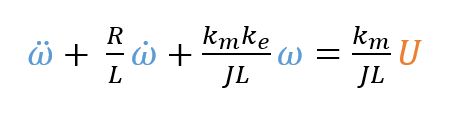

Импортируем необходимые модули

In [204]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.integrate import odeint

Задаем начальные значения переменных

In [205]:
experiment_angle = []
experiment_time = []

Umax = 8.34
ke = 0.4910273
km = 0.4910273
L = 0.0047
J = 0.00243763
R = 8.3293842
target = 260/180*3.14

error = target
integral = 0
deriv = 0

t = np.linspace(0, 7, 1000)
dt = 7 / 1000
initial = np.zeros(2)
omega_arr = [0]

Задаем функцию clamp_precent, которая преобразует напряжение из % в Вольты, ограничивая напряжение в процентах на интервале [-100, 100], функции to_degrees, to_radians для перевода из радиан в градусы и наоборот.


In [206]:
def clamp_percent(value):
  value = int(value)
  if value > 100:
    value = 100
  if value < -100:
    value = -100

  return Umax*value/100


to_degrees = lambda radians: radians/3.14*180

to_radians = lambda degrees: degrees/180.0*3.14

Зададим функцию model, реализующую полную математическую модель ДПТ.


Выражение производной второго порядка через производные низшего порядка

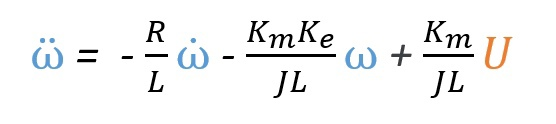

In [207]:
def model(init, t,  u):
  Omega = init[0]
  dOmega = init[1]
  dOmegadt = np.empty(2)
  # производная первого порядка
  dOmegadt[0] = dOmega 
  # производная второго порядка
  dOmegadt[1] = -(R / L) * dOmega - (km * ke) / (J * L) * Omega + km / (J * L) * u
  return dOmegadt

Зададим функцию update, которая возвращает решение дифференциального уравнения ω

In [208]:
def update(t, u):
  solution = odeint(model, initial, t, args=(u,))
  return solution[-1]

Задаем функции calc_U, relay для рассчета подаваемого напряжения

In [209]:
def calc_U(kp, ki, kd):

  U = kp*to_degrees(error) + ki*to_degrees(integral) + kd*to_degrees(deriv)
  return clamp_percent(U)

def relay():
  if error > 0:
    return Umax
  if error < 0:
    return -Umax
  return 0

Основной цикл программы. В нем мы решаем дифференциальное уравнение относительно ω для каждых двух соседних точек времени, при этом используя значения ω для предыдущего момента времени

In [210]:
for i in range(t.shape[0] - 1):
  angle = 0
  angle_arr = [angle]
  for speed in omega_arr:
    angle += speed * dt
    angle_arr.append(angle)
  error = target - angle_arr[-1]
  integral += (target - angle_arr[-1])*dt
  deriv = (target - angle_arr[-1] - (target - angle_arr[-2]))/dt
  u = calc_U(0.5, 0, 0)
  
  ts = [t[i], t[i+1]]
  initial = update(ts, u)
  
  omega_arr.append(initial[0])

Считывание экспериментальных данных из файла

In [211]:
with open("/content/drive/MyDrive/data/p_reg_k0.5.txt", 'r') as file:
  for line in file.readlines():
    e_time, e_angle = line.split()
    experiment_angle.append(to_radians(float(e_angle)))
    experiment_time.append(float(e_time))

Построение графиков

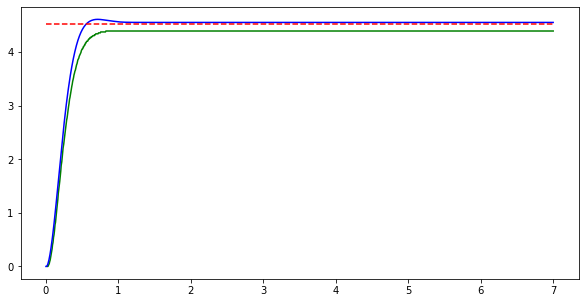

In [212]:
plt.figure(figsize=(10,5))
plt.plot(experiment_time, experiment_angle, "g-")
plt.plot(t, angle_arr, "b-")
plt.plot([0, 7], [target, target], "r--")

In [213]:
def draw(filepath, kp, ki, kd, is_relay=False):
  import matplotlib.pyplot as plt
  import numpy as np
  import sympy as sp
  from scipy.integrate import odeint
  experiment_angle = []
  experiment_time = []

  Umax = 8.34
  ke = 0.488
  km = 0.488
  L = 0.0047
  J = 0.00243763
  R = 8.204
  target = 260/180*3.14

  error = target
  integral = 0
  deriv = 0

  t = np.linspace(0, 7, 1000)
  dt = 7 / 1000
  initial = np.zeros(2)
  omega_arr = [0]
  def clamp_percent(value):
    value = int(value)
    if value > 100:
      value = 100
    if value < -100:
      value = -100

    return Umax*value/100


  to_degrees = lambda radians: radians/3.14*180

  to_radians = lambda degrees: degrees/180.0*3.14

  def model(init, t,  u):
    Omega = init[0]
    dOmega = init[1]
    dOmegadt = np.empty(2)
    # производная первого порядка
    dOmegadt[0] = dOmega 
    # производная второго порядка
    dOmegadt[1] = -(R / L) * dOmega - (km * ke) / (J * L) * Omega + km / (J * L) * u
    return dOmegadt

  def update(t, u):
    solution = odeint(model, initial, t, args=(u,))
    return solution[-1]

  def calc_U(kp, ki, kd):

    U = kp*to_degrees(error) + ki*integral + kd*deriv
    return clamp_percent(U)

  def relay():
    if error > 0:
      return Umax
    if error < 0:
      return -Umax
    return 0

  for i in range(t.shape[0] - 1):
    angle = 0
    angle_arr = [angle]
    for speed in omega_arr:
      angle += speed * dt
      angle_arr.append(angle)
    error = target - angle_arr[-1]
    integral += (target - angle_arr[-1])*dt
    deriv = (target - angle_arr[-1] - (target - angle_arr[-2]))/dt
    if is_relay:
      u = relay()
    else:
      u = calc_U(kp, ki, kd)
    
    ts = [t[i], t[i+1]]
    initial = update(ts, u)
    
    omega_arr.append(initial[0])

  with open(filepath, 'r') as file:
    for line in file.readlines():
      e_time, e_angle = line.split()
      experiment_angle.append(to_radians(float(e_angle)))
      experiment_time.append(float(e_time))

  plt.figure(figsize=(10,5))
  plt.plot(experiment_time, experiment_angle, "g-")
  plt.plot(t, angle_arr, "b-")
  plt.plot([0, 7], [target, target], "r--")

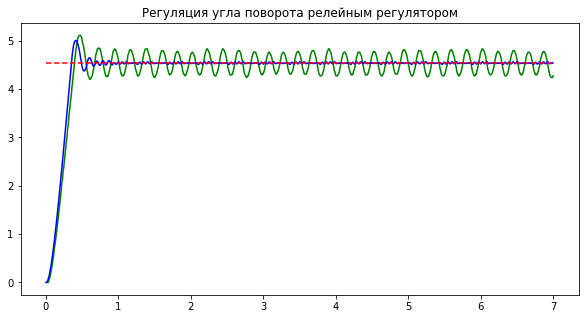

In [214]:
draw("/content/drive/MyDrive/data/relay.txt", 0, 0, 0, is_relay=True)
plt.title("Регуляция угла поворота релейным регулятором")
plt.show()

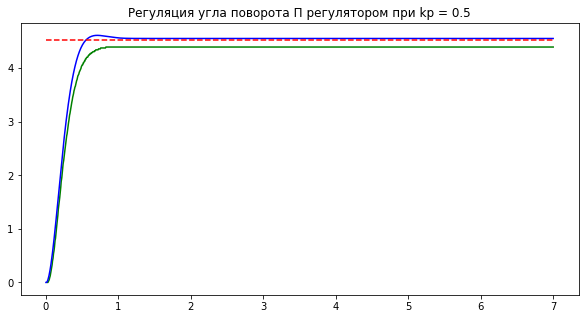

In [215]:
draw("/content/drive/MyDrive/data/p_reg_k0.5.txt", 0.5, 0, 0)
plt.title("Регуляция угла поворота П регулятором при kp = 0.5")
plt.show()

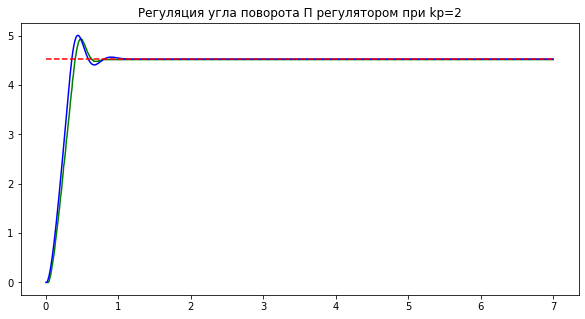

In [216]:
draw("/content/drive/MyDrive/data/p_reg_k2.txt", 2, 0, 0)
plt.title("Регуляция угла поворота П регулятором при kp=2")
plt.show()

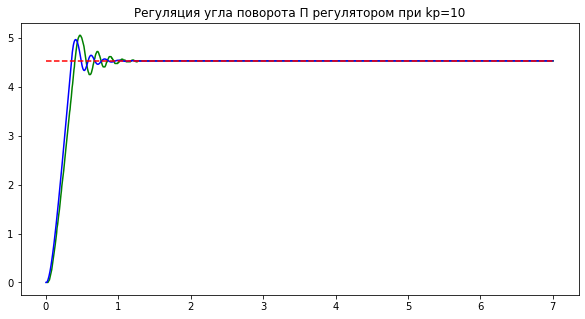

In [217]:
draw("/content/drive/MyDrive/data/p_reg_k10.txt", 10, 0, 0)
plt.title("Регуляция угла поворота П регулятором при kp=10")
plt.show()

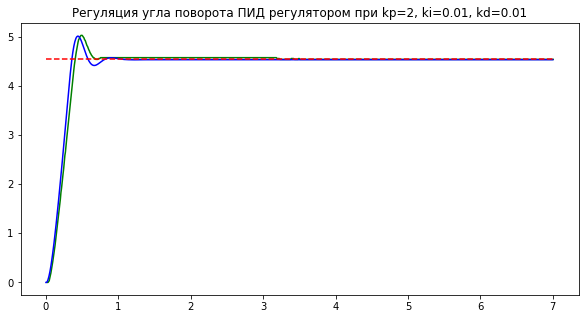

In [218]:
draw("/content/drive/MyDrive/data/pid_reg2_0.01_0.01.txt", 2, 0.01, 0.01)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.01, kd=0.01")
plt.show()

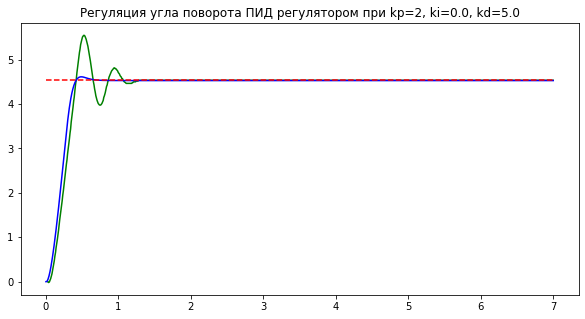

In [219]:
draw("/content/drive/MyDrive/data/pid_reg205.txt", 2, 0.0, 5.0)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.0, kd=5.0")
plt.show()

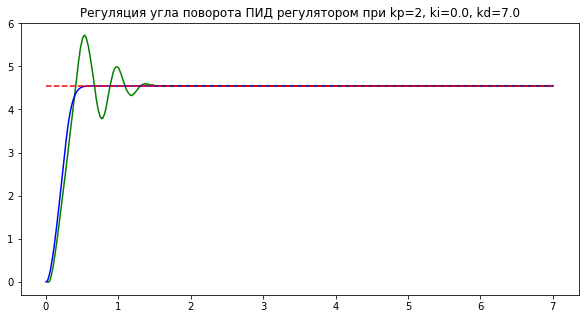

In [220]:
draw("/content/drive/MyDrive/data/pid_reg207.txt", 2, 0.0, 7)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.0, kd=7.0")
plt.show()

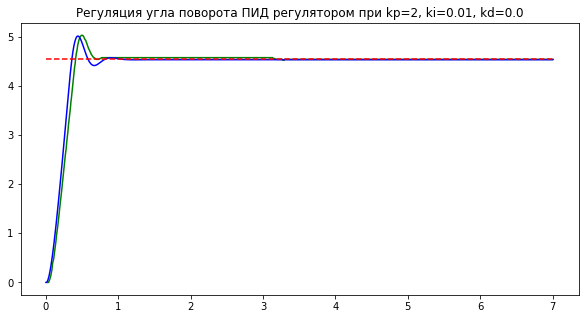

In [221]:
draw("/content/drive/MyDrive/data/pid_reg2_001_0.txt", 2, 0.01, 0)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.01, kd=0.0")
plt.show()

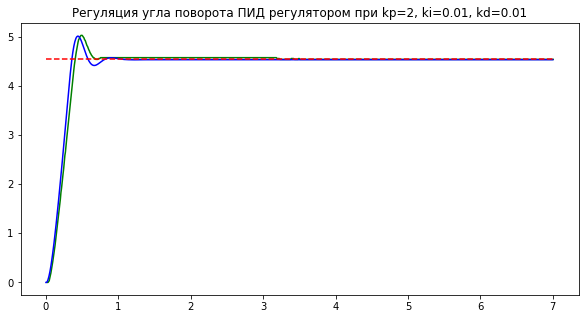

In [222]:
draw("/content/drive/MyDrive/data/pid_reg2_0.01_0.01.txt", 2, 0.01, 0.01)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.01, kd=0.01")
plt.show()

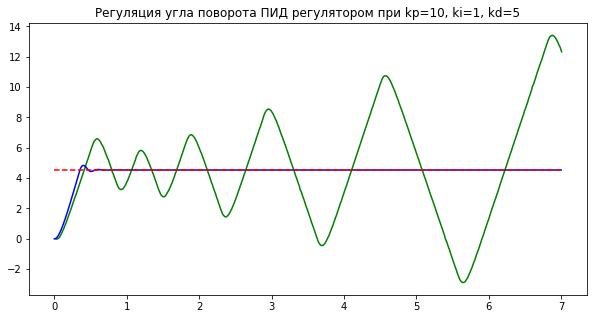

In [223]:
draw("/content/drive/MyDrive/data/pid_reg10_1_5.txt", 10, 1, 5)
plt.title("Регуляция угла поворота ПИД регулятором при kp=10, ki=1, kd=5")
plt.show()

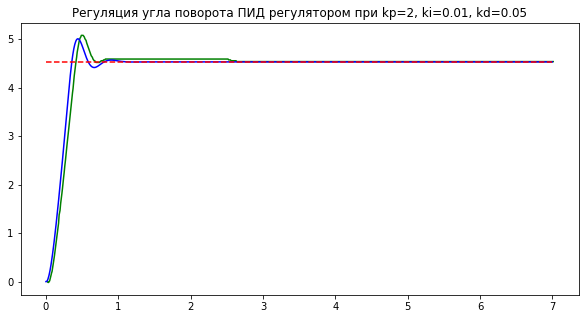

In [224]:
draw("/content/drive/MyDrive/data/pid_reg2_0.01_0.05.txt", 2, 0.01, 0.05)
plt.title("Регуляция угла поворота ПИД регулятором при kp=2, ki=0.01, kd=0.05")
plt.show()

# Вывод


*   В ходе выполнения данной работы мы изучили процесс регулирования двигателя 
постоянного тока, познакомились с принципами работы релейного регулятора, П-регулятора 
и ПИД-регулятора.

*   Изучили влияние коэффициентов
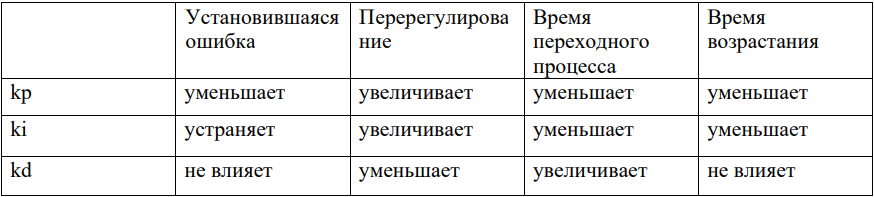

